In [3]:
# based on https://wroscoe.github.io/keras-lane-following-autopilot.html

import os
import urllib.request
import pickle
import numpy as np
import cv2
from tools import import_data, shuffle_data, split_data

%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow, imread

# Get Data

In [4]:
raw_X, raw_y = import_data('../inloop')
print('X shape: ', raw_X.shape)
print('y shape: ', raw_y.shape)

X shape:  (2336, 128, 160, 3)
y shape:  (2336,)


In [5]:
shuffled_X, shuffled_y = shuffle_data(raw_X, raw_y)

In [11]:
train_X, train_y, val_X, val_y, test_X, test_y = split_data(shuffled_X, shuffled_y, 0.8, 0.1)

print('Train: ', len(train_X))
print('Val:   ', len(val_X))
print('Test:  ', len(test_X))
print('Total: ', len(train_X) + len(val_X) + len(test_X))

Train:  1868
Val:    233
Test:   235
Total:  2336


In [12]:
# flip images to remove steering bias
X_flipped = np.array([np.fliplr(i) for i in train_X])
y_flipped = np.array([-i for i in train_y])
train_X = np.concatenate([train_X, X_flipped])
train_y = np.concatenate([train_y, y_flipped])
len(train_X)

3736

In [6]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D

Using TensorFlow backend.


# Model used by William Roscoe for the Donkey SDC

In [7]:
model = Sequential()
model.add(Convolution2D(8, (3,3), input_shape=(128, 160, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(16, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('linear'))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 158, 8)       224       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 158, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 79, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 77, 16)        1168      
_________________________________________________________________
activation_2 (Activation)    (None, 61, 77, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 38, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 36, 32)        4640      
__________

# Train

In [8]:
from keras import callbacks
model_path = os.getcwd() + '/models/model.hdf5'
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [9]:
model.fit(train_X, train_y, batch_size=32, epochs=30, validation_data=(val_X, val_y), callbacks=callbacks_list)

Train on 3736 samples, validate on 233 samples
Epoch 1/30
3736/3736 [==============================] - 43s - loss: 37833.2210 - val_loss: 3794.4274
Epoch 2/30
3736/3736 [==============================] - 41s - loss: 3149.2357 - val_loss: 2822.5329
Epoch 3/30
3736/3736 [==============================] - 40s - loss: 2698.7987 - val_loss: 2874.9804
Epoch 4/30
3736/3736 [==============================] - 41s - loss: 2410.9005 - val_loss: 2638.5787
Epoch 5/30
3736/3736 [==============================] - 41s - loss: 2181.2653 - val_loss: 2638.5923
Epoch 6/30
3736/3736 [==============================] - 41s - loss: 2082.6176 - val_loss: 2380.5036
Epoch 7/30
3736/3736 [==============================] - 42s - loss: 1977.0623 - val_loss: 2391.0558
Epoch 8/30
3736/3736 [==============================] - 46s - loss: 1819.8665 - val_loss: 2551.9892
Epoch 9/30
3736/3736 [==============================] - 51s - loss: 1802.8317 - val_loss: 2371.1269
Epoch 10/30
3736/3736 [=============================

# Evaluate

In [10]:
import pandas as pd
from keras.models import load_model
model = load_model(model_path)

# Test Data

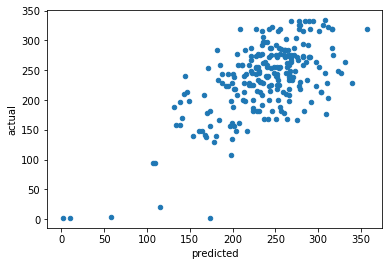

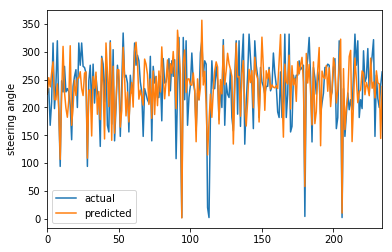

In [11]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape((pred_y.shape[0],))
df = pd.DataFrame({'predicted':pred_y, 'actual':test_y})
ax = df.plot.scatter('predicted', 'actual')
ax2 = pd.DataFrame({'predicted':pred_y, 'actual':test_y}).plot()
ax2.set_ylabel('steering angle')

# Training Data

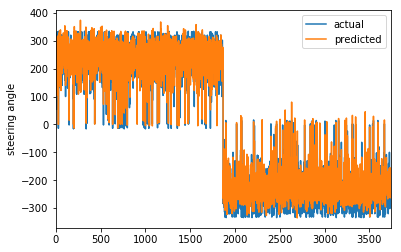

In [12]:
pred_y_2 = model.predict(train_X)
pred_y_2 = pred_y_2.reshape((pred_y_2.shape[0],))

ax = pd.DataFrame({'predicted':pred_y_2, 'actual':train_y}).plot()
ax.set_ylabel('steering angle')

In [17]:
print(model.predict(train_X[1:2]))

[[ 262.27590942]]


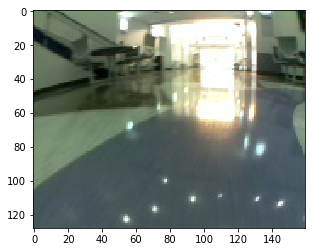

In [19]:
imshow(train_X[1])